<h1><center> Facial Emotion Recognition - Pre-processing with EmotionalDAN</center></h1>
<center> A project for the French Employment Agency </center>
<center> Telecom ParisTech 2018-2019 </center>

# I. Context

The aim of this notebook is to explore facial emotion recognition techniques from a live webcam video stream. 

The data set used for training is the Kaggle FER2013 emotion recognition data set : https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data

The models explored include :
- Manual filters 
- Deep Learning Architectures
- DenseNet Inspired Architectures

This model will be combined with voice emotion recongition as well as psychological traits extracted from text inputs, and should provide a benchmark and a deep analysis of both verbal and non-verbal insights for candidates seeking for a job and their performance during an interview.

# II. General imports

Versions used :

In [1]:
### General imports ###
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from time import sleep
import re
import os
import argparse
from collections import OrderedDict
import matplotlib.animation as animation

### Image processing ###
from scipy.ndimage import zoom
from scipy.spatial import distance
import imutils
from scipy import ndimage
import cv2
import dlib
from __future__ import division
from imutils import face_utils

### CNN models ###
import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D
from keras.utils import np_utils
from keras.regularizers import l2#, activity_l2
from keras.optimizers import SGD, RMSprop
from keras.utils import to_categorical
from keras.layers.normalization import BatchNormalization
from keras import models
from keras.utils.vis_utils import plot_model
from keras.layers import Input, GlobalAveragePooling2D
from keras.models import Model
from tensorflow.keras import layers

### Build SVM models ###
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm

### Same trained models ###
import h5py
from keras.models import model_from_json
import pickle

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/anaconda3/lib/python3.6/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.21.1) or chardet (2.3.0) doesn't match a supported version!
  RequestsDependencyWarning)


# III. Import datas

In [2]:
path = '/Users/maelfabien/filrouge_pole_emploi/Video/'
local_path = '/Users/maelfabien/Desktop/LocalDB/Videos/'

In [3]:
pd.options.mode.chained_assignment = None  # default='warn'  #to suppress SettingWithCopyWarning

#Reading the dataset
dataset = pd.read_csv(local_path + 'fer2013.csv')

#Obtaining train data where usage is "Training"
train = dataset[dataset["Usage"] == "Training"]

#Obtaining test data where usage is "PublicTest"
test = dataset[dataset["Usage"] == "PublicTest"]

#Converting " " separated pixel values to list
train['pixels'] = train['pixels'].apply(lambda image_px : np.fromstring(image_px, sep = ' '))
test['pixels'] = test['pixels'].apply(lambda image_px : np.fromstring(image_px, sep = ' '))

In [4]:
dataset.head()

emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training

In [5]:
dataset[dataset['emotion'] == 1].head()

emotion                                             pixels     Usage
299        1  126 126 129 120 110 168 174 172 173 174 170 15...  Training
388        1  89 55 24 40 43 48 53 55 59 41 33 31 22 32 42 4...  Training
416        1  204 195 181 131 50 50 57 56 66 98 138 161 173 ...  Training
473        1  14 11 13 12 41 95 113 112 111 122 132 137 142 ...  Training
533        1  18 25 49 75 89 97 100 100 101 103 105 107 107 ...  Training

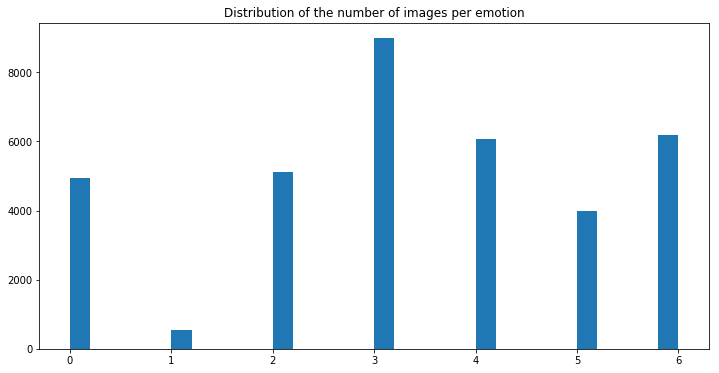

In [6]:
plt.figure(figsize=(12,6))
plt.hist(dataset['emotion'], bins=30)
plt.title("Distribution of the number of images per emotion")
plt.show()

In [7]:
train.shape

(28709, 3)

In [8]:
test.shape

(3589, 3)

# IV. Create the data set

In [9]:
shape_x = 48
shape_y = 48

In [10]:
X_train = train.iloc[:, 1].values
y_train = train.iloc[:, 0].values
X_test = test.iloc[:, 1].values
y_test = test.iloc[:, 0].values

#np.vstack stack arrays in sequence vertically (picking element row wise)
X_train = np.vstack(X_train)
X_test = np.vstack(X_test)

#Reshape X_train, y_train,X_test,y_test in desired formats
X_train = np.reshape(X_train, (X_train.shape[0],48,48,1))
y_train = np.reshape(y_train, (y_train.shape[0],1))
X_test = np.reshape(X_test, (X_test.shape[0],48,48,1))
y_test = np.reshape(y_test, (y_test.shape[0],1))

print("Shape of X_train and y_train is " + str(X_train.shape) +" and " + str(y_train.shape) +" respectively.")
print("Shape of X_test and y_test is " + str(X_test.shape) +" and " + str(y_test.shape) +" respectively.")

Shape of X_train and y_train is (28709, 48, 48, 1) and (28709, 1) respectively.
Shape of X_test and y_test is (3589, 48, 48, 1) and (3589, 1) respectively.


In [11]:
# Change to float datatype
train_data = X_train.astype('float32')
test_data = X_test.astype('float32')

# Scale the data to lie between 0 to 1
train_data /= 255
test_data /= 255

# Change the labels from integer to categorical data
train_labels_one_hot = to_categorical(y_train)
test_labels_one_hot = to_categorical(y_test)

# V. Define the number of classes

In [12]:
# Find the unique numbers from the train labels
classes = np.unique(y_train)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

# Find the shape of input images and create the variable input_shape
nRows,nCols,nDims = X_train.shape[1:]
input_shape = (nRows, nCols, nDims)

Total number of outputs :  7
Output classes :  [0 1 2 3 4 5 6]


In [13]:
#Defining labels 
def get_label(argument):
    labels = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad' , 5:'Surprise', 6:'Neutral'}
    return(labels.get(argument, "Invalid emotion"))

Text(0.5, 1.0, 'Ground Truth : Surprise')

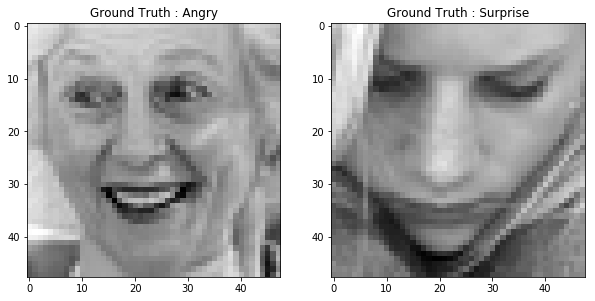

In [14]:
plt.figure(figsize=[10,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(np.squeeze(X_train[25,:,:], axis = 2), cmap='gray')
plt.title("Ground Truth : {}".format(get_label(int(y_train[0]))))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(np.squeeze(X_test[26,:,:], axis = 2), cmap='gray')
plt.title("Ground Truth : {}".format(get_label(int(y_test[1500]))))

# VI. Emotional Deep Alignment Networks

This is an implementation of the paper : https://arxiv.org/pdf/1810.10529.pdf

The main advantage of DAN over the competing
face alignment methods comes from an iterative process
of adjusting the locations of facial landmarks. The iterations are incorporated into the neural network architecture, as the information about the landmark locations detected in the previous stage (layer) are transferred to the
next stages through the use of facial landmark heatmaps.
As a result and contrary to the competing methods, DAN
can therefore handle entire face images instead of patches
which leads to a significant reduction in head pose variance
and improves its performance on a landmark recognition
task. 

Even though during training model has only information about emotion label, spatial information about
regions containing information relevant to expressed emotions are correctly captured. Face regions around
eyes and mouth influence model’s decision the most for all emotion classes. Eyebrow location and strength of
activations near nose (e.g Disgust) also show some discriminative information.

In [16]:
import math

from tensorflow.python.eager import context
from tensorflow.python.framework import constant_op
from tensorflow.python.framework import dtypes
from tensorflow.python.framework import ops
from tensorflow.python.ops import control_flow_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import random_ops
from tensorflow.python.util.tf_export import tf_export

from skimage.transform import resize
from skimage import color
import tensorflow as tf

In [21]:
emotionDict7 = {0: 'Neutral', 1: 'Happiness', 2: 'Sadness',
                3: 'Surprise', 4: 'Fear', 5: 'Disgust', 6: 'Anger'}

IMGSIZE = 2304

In [22]:
def get_gradcam(batch_img, batch_label, modelPath, dan, tf_sess,
                img_mask=1, img_size=IMGSIZE, conv_layer='S2_Conv4a', logging=False):
    # TODO: fix for batch size > 1

    images = tf.placeholder(tf.float32, [None, img_size, img_size, 1])
    labels = tf.placeholder(tf.float32, [None, ])

    # gradient for partial linearization. We only care about target
    # visualization class.
    y_c = tf.reduce_sum(tf.multiply(dan['S2_Emotion'], labels), axis=1)

    # Get last convolutional layer gradient for generating gradCAM
    # visualization
    target_conv_layer = dan[conv_layer]
    target_conv_layer_grad = tf.gradients(y_c, target_conv_layer)[0]

    # Run inference of prediction class
    prob, softmax = tf_sess.run([dan['Pred_emotion'], dan['softmax']],
                       {dan['InputImage']: batch_img,
                        dan['S1_isTrain']: False,
                        dan['S2_isTrain']: False})
    if logging:
        # print(prob)
        # print(softmax)
        print('Predicted emotion:', emotionDict7[prob[0]])
        print('True emotion', emotionDict7[batch_label[0]])
        for i in range(len(softmax[0])):
            print(emotionDict7[i], softmax[0][i])
        

    # Do not generate cam if predicted class is not correct
    if prob[0] != batch_label[0]:
        return []

    target_conv_layer_value, target_conv_layer_grad_value = tf_sess.run(
        [target_conv_layer, target_conv_layer_grad],
        feed_dict={images: batch_img,
                   labels: batch_label,
                   dan['InputImage']: batch_img,
                   dan['S1_isTrain']: False,
                   dan['S2_isTrain']: False})

    batch_size = len(batch_img)

    for i in range(batch_size):

        output, grads_val = target_conv_layer_value[i], target_conv_layer_grad_value[i]
        weights = np.mean(grads_val, axis=(0, 1))

        cam = np.zeros(output.shape[0: 2], dtype=np.float32)
        for j, w in enumerate(weights):
            cam += w * output[:, :, j]

        # Passing through ReLU
        cam = np.maximum(cam, 0)
        cam = cam / np.max(cam)  # scale 0 to 1.0
        cam = resize(cam, (img_size, img_size), preserve_range=True)

        return cam

In [23]:
def get_heatmap(cam):
    """Returns heatmap of generated gradcam"""
    cam_heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    cam_heatmap = cv2.cvtColor(cam_heatmap, cv2.COLOR_BGR2RGB)
    return cam_heatmap


def overlay_cam(img, cam, alpha, show=True, outFile=None):
    if len(cam) > 0:
        cam_heatmap = get_heatmap(cam)

        img = img.astype(float)
        img = img - np.min(img)
        img = img / np.max(img)

        # Construct RGB version of grey-level image
        img_color = np.dstack((img, img, img))

        # Convert the input image and color mask to Hue Saturation Value (HSV)
        # colorspace
        img_hsv = color.rgb2hsv(img_color)
        color_mask_hsv = color.rgb2hsv(cam_heatmap)

        # Replace the hue and saturation of the original image
        # with that of the color mask
        img_hsv[..., 0] = color_mask_hsv[..., 0]
        img_hsv[..., 1] = color_mask_hsv[..., 1] * alpha

        img_masked = color.hsv2rgb(img_hsv)

        if show:
            fig = plt.figure(figsize=(12, 16))
            ax = fig.add_subplot(222)
            plt.imshow(img_masked)
            ax.axis('off')
            ax.set_title('Grad-CAM')

            plt.show()

            if outFile:
                plt.savefig(outFile)

        return img_masked


def plot_mean_cam(cams):
    cams_num = [
        c for c in cams if (
            not np.isnan(c).any()) and (
            len(c) > 0)]
    print('Nb of images: {}, non nan: {}'.format(len(cams), len(cams_num)))
    if len(cams_num) > 0:
        cams_sum = sum(cams_num) / len(cams_num)
        cam_heatmap = cv2.applyColorMap(
            np.uint8(255 * cams_sum), cv2.COLORMAP_JET)
        cam_heatmap = cv2.cvtColor(cam_heatmap, cv2.COLOR_BGR2RGB)
        plt.imshow(cam_heatmap)
        plt.show()


def get_mean_cam(cams):
    cams_num = [
        c for c in cams if (
            not np.isnan(c).any()) and (
            len(c) > 0)]
#     print('Nb of images: {}, non nan: {}'.format(len(cams), len(cams_num)))
    if len(cams_num) > 0:
        cams_sum = sum(cams_num) / len(cams_num)
        cam_heatmap = cv2.applyColorMap(
            np.uint8(255 * cams_sum), cv2.COLORMAP_JET)
        cam_heatmap = cv2.cvtColor(cam_heatmap, cv2.COLOR_BGR2RGB)
        plt.imshow(cam_heatmap)
        return cams_sum


def find_closest_image_to_gradcam(emotion_id, gradcams, id_to_img_dict):
    mean_gradcam = get_mean_cam(gradcams[emotion_id - 1])
    res, res_i = find_closest(gradcams[emotion_id - 1], mean_gradcam)
    res_image = np.reshape(id_to_img_dict[emotion_id, res_i], (224, 224))
    return res_image, res


def visualize(batch_img, batch_label, modelPath, dan, sess, img_mask=1, batch_size=1,
              img_size=224, alpha=0.5, conv_layer='S2_Conv4b', vis_type='overlay', outFile=None):
    """Plot GradCam visualization for given image"""
    cam = get_gradcam(batch_img, batch_label, modelPath, dan,
                      sess, img_mask, img_size, conv_layer, logging=True)

    # if len(cam) > 0:
    #     cam_heatmap = get_heatmap(cam)
    # else:
    #     return None

    if vis_type == 'overlay':
        img = batch_img[0]
        overlay_cam(img, cam, alpha, show=True, outFile=outFile)


def get_most_activated_landmarks(
        cam, gt_landmarks, k, radius=3, img_size=224):
    """function that returns a number of landmarks that
    are most activated by gradcam

    for each gt landmark, activations in the area of radius r around landmark are summed
    (gt_x - r, gt_x + r)
    (gt_y - r, gt_y + r)

    k results are returned
    """
    landmark_activations = {}

    x_s = gt_landmarks[0:][::2]
    y_s = gt_landmarks[1:][::2]

    for x_, y_ in zip(x_s, y_s):
        x = min(int(x_), img_size - 1)
        y = min(int(y_), img_size - 1)

        landmark_activations[x, y] = 0
        # Add activations from around landmarks
        for r in range(radius):
            for s in range(radius):
                try:
                    landmark_activations[x, y] += cam[y + s][x + r]
                except IndexError:
                    print('')
    inverse = [(value, key) for key, value in landmark_activations.items()]
    sorted_inverse = sorted(inverse)[-k:]
    activated_landmarks = [b for _, b in sorted_inverse]
    return activated_landmarks


In [19]:
def e_distance(a, b):
    return np.linalg.norm(a - b)

In [20]:
def find_closest(matrix_list, target_matrix):
    min_distance = 999999
    closest_matrix = None
    closest_id = None
    for i, m in enumerate(matrix_list):
        if len(m) > 0:
            dist = e_distance(m, target_matrix)
            if dist < min_distance:
                closest_matrix = m
                closest_id = i
                min_distance = dist
    return closest_matrix, closest_id

# VII. Save the dataframes

In [22]:
np.save(local_path + 'X_train_augmented', train_data)

In [19]:
np.save(local_path + 'X_test_augmented', test_data)

In [20]:
np.save(local_path + 'y_train_augmented', train_labels_one_hot)

In [21]:
np.save(local_path + 'y_test_augmented', test_labels_one_hot)

# VIII. Sources

- Visualization : https://github.com/JostineHo/mememoji/blob/master/data_visualization.ipynb
- State of the art Architecture : https://github.com/amineHorseman/facial-expression-recognition-using-cnn
- Eyes Tracking : https://www.pyimagesearch.com/2017/04/24/eye-blink-detection-opencv-python-dlib/
- Face Alignment : https://www.pyimagesearch.com/2017/05/22/face-alignment-with-opencv-and-python/
- C.Pramerdorfer,  and  M.Kampel.Facial  Expression  Recognition  using  Con-volutional  Neural  Networks:  State  of  the  Art.  Computer  Vision  Lab,  TU  Wien. https://arxiv.org/pdf/1612.02903.pdf
- A Brief Review of Facial Emotion Recognition Based
on Visual Information : https://www.mdpi.com/1424-8220/18/2/401/pdf
- Going deeper in facial expression recognition using deep neural networks : https://ieeexplore.ieee.org/document/7477450
- Emotional Deep Alignment Network paper : https://arxiv.org/abs/1810.10529
- Emotional Deep Alignment Network github : https://github.com/IvonaTau/emotionaldan